# Example Layer Wise Relevance Propagation

In [3]:
! pip install torch torchvision numpy pydantic umap-learn interpret faiss-cpu torchsummary matplotlib pandas seaborn scikit-learn scikit-image pytorch-lightning[extra] --no-cache-dir --ignore-installed

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
autovizwidget 0.20.5 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.0.3 which is incompatible.
botocore 1.31.42 requires urllib3<1.27,>=1.25.4, but you have urllib3 2.0.5 which is incompatible.
hdijupyterutils 0.20.5 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.3 which is incompatible.
jupyterlab 3.2.1 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
jupyterlab 3.2.1 requires nbclassic~=0.2, but you have nbclassic 1.0.0 which is incompatible.
jupyterlab-server 2.8.2 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
notebook 6.5.5 requir

In [4]:
import os
import torch
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning import Trainer
from torchvision.transforms import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from models.vgg import VGG
from models.callbacks import PrintAccuracyAndLoss
from data.brain_tumor_mri import BrainTumorMRI
from interpret.layer_wise_rp import LayerWiseRP
from viz.lwrp import plot_relevance, analyze_example

from sklearn.metrics.cluster import normalized_mutual_info_score

from torchmetrics import Accuracy

In [5]:
RND_SEED=31
torch.manual_seed(RND_SEED)
torch.cuda.manual_seed_all(RND_SEED)
np.random.seed(RND_SEED)

In [14]:
DEBUG = False

In [12]:
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device("cpu:0")
BATCH_SIZE = 32
NUM_WORKERS = 8
DATASETS_PATH = '/root/xai-clustering/datasets/'
EPOCHS = 30
brain_tumor = BrainTumorMRI(DATASETS_PATH)

# MODEL

In [15]:
model = VGG()

# PATH = "./xai-clustering/checkpoints/best-checkpoint.ckpt"
# model = CNNLightModel.load_from_checkpoint(PATH)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-cnn-checkpoint",
    save_top_k=6,
    verbose=True,
    monitor="val_loss",
    mode="min"
)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3)
print_acc_and_loss_callback = PrintAccuracyAndLoss()

trainer = Trainer(
    max_epochs=EPOCHS,
    fast_dev_run=DEBUG,
    callbacks=[print_acc_and_loss_callback, early_stopping_callback, checkpoint_callback]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## TRAINING

In [ ]:
training_results = trainer.fit(
    model,
    train_dataloaders=brain_tumor.train_dataloader,
    val_dataloaders=brain_tumor.val_dataloader
)

Missing logger folder: /root/xai-clustering/lightning_logs

  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 14.7 M
1 | avgpool           | AdaptiveAvgPool2d  | 0     
2 | classifier        | Sequential         | 119 M 
3 | loss_fn           | CrossEntropyLoss   | 0     
4 | train_acc         | MulticlassAccuracy | 0     
5 | val_acc           | MulticlassAccuracy | 0     
6 | test_acc          | MulticlassAccuracy | 0     
---------------------------------------------------------
16.4 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 179: 'val_loss' reached 0.70722 (best 0.70722), saving model to '/root/xai-clustering/checkpoints/best-cnn-checkpoint.ckpt' as top 6


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 358: 'val_loss' reached 0.56851 (best 0.56851), saving model to '/root/xai-clustering/checkpoints/best-cnn-checkpoint-v1.ckpt' as top 6


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 537: 'val_loss' reached 0.50972 (best 0.50972), saving model to '/root/xai-clustering/checkpoints/best-cnn-checkpoint-v2.ckpt' as top 6


# TESTING

In [ ]:
test_results = trainer.test(model, dataloaders=brain_tumor.test_dataloader)

In [ ]:
test_results[0].get('test_loss')

# ANALYZING MODEL

In [ ]:
# plot graphs to check overfitting

# ANALYZING IMAGES

Ground Truth for this image:  0
Prediction was:  0


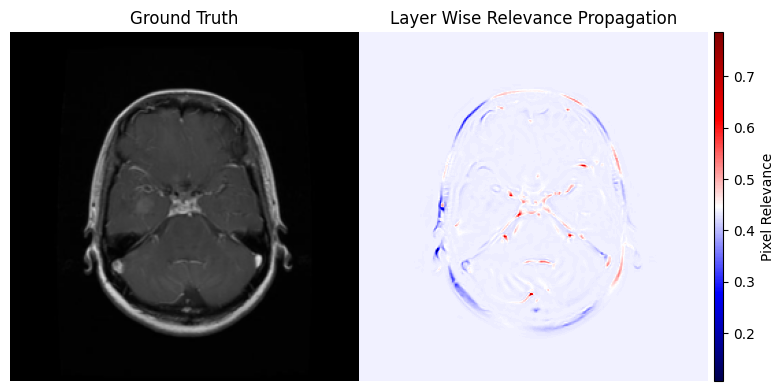

In [4]:
data, labels = brain_tumor.get_sample_batch()
lw = LayerWiseRP()

image_id = 13
image_1 = data[image_id]
image_lwrp = lw.apply(model, image_1, DEVICE)
image_1 = image_1.unsqueeze(0)
image_1_label = labels[image_id]
image_1_pred = model(image_1).max(1).indices.detach().cpu().numpy()
image_1 = image_1.squeeze(0)

analyze_example(
    image=F.to_pil_image(image_1),
    label=image_1_label,
    image_lwrp=image_lwrp[:,:,0],
    pred_label=image_1_pred[0]
)